In [1]:
from data_helper import get_dataloaders_and_standarscaler_photons_from_numpy
from plot_helper import plot_training_loss

import copy
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn

In [2]:
# Hyperparameters
FRACTION_PLOT=0.0125
path='/data1/dose-3d-generative/data/training-data/PHSPs_without_VR/Filtered_E5.6_s0.0.npy'
LOAD_CHECKPOINT_PATH="/home/jakmic/Projekty/dose3d-phsp/AE_VAE/Autoencoders_Photons/TrainedModels/InfoVAE/90epoch_2703_mmd_checkpoint.pth"

In [3]:
loaded_checkpoint = torch.load(LOAD_CHECKPOINT_PATH)
NUM_EPOCHS = loaded_checkpoint["epoch"]
print(NUM_EPOCHS)
model_name=loaded_checkpoint["model_name"]
print(model_name)

45
VAE_Linear_2703


In [4]:
model = getattr(__import__('models_architecture_helper', fromlist=[model_name]), model_name)

In [5]:
model=model()
# model.to(DEVICE)
model.load_state_dict(loaded_checkpoint["model_state"])


optimizer = torch.optim.Adam(model.parameters(),
                             lr=0, 
                             weight_decay=1e-5)

optimizer.load_state_dict(loaded_checkpoint["optim_state"])
BATCH_SIZE = loaded_checkpoint["batch_size"]
RECONSTRUCTION_TERM_WEIGHT = loaded_checkpoint["reconstruction_term_weight"]
log_dict=loaded_checkpoint["log_dict"]

In [6]:
#ODCZYTANIE DANYCH Z PLIKU 'photons.npy'
random.seed(123)
photons = np.load(path)
for photon in photons:
    if random.uniform(0,1)>0.5:
        photon[1]=-photon[1]
        photon[2]=-photon[2]
        photon[3]=-photon[3]
        photon[4]=-photon[4]

# print(photons[0:10,:])

# X = np.zeros((12719568, 6),dtype=np.float32)
# np.copyto(X,photons[:,:])
# print(X.shape)

In [7]:
# X_reflection=copy.deepcopy(X)
# X_reflection[:,2]=-X_reflection[:,2]
# X_reflection[:,4]=-X_reflection[:,4]

# X_sum=np.concatenate((X,X_reflection),axis=0)
# print(len(X_sum))

In [8]:
df_data = pd.DataFrame(photons, columns = ['E','X', 'Y', 'dX', 'dY', 'dZ'])
df_data.head()#zawsze warto rzucić okiem na dane

E        X        Y        dX        dY        dZ
0  4.45203 -4.39070 -2.44528 -0.169138 -0.094289  0.981072
1  0.34110 -3.09801 -3.97138 -0.119365 -0.153048  0.980983
2  1.04284  2.69596 -1.92596  0.104983 -0.074969  0.991644
3  2.84573  4.25968 -1.85673  0.164585 -0.071678  0.983755
4  0.75520  2.39109  0.23989  0.093510  0.009379  0.995574

In [9]:
train_loader, valid_loader, test_loader, stdcs = get_dataloaders_and_standarscaler_photons_from_numpy(tmp_X=photons,
    batch_size=BATCH_SIZE, 
    num_workers=0,
    test_fraction=0.4, 
    validation_fraction=0.0)

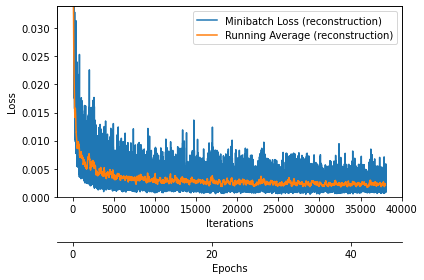

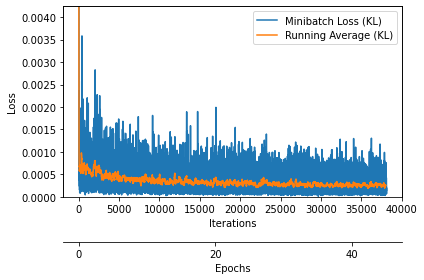

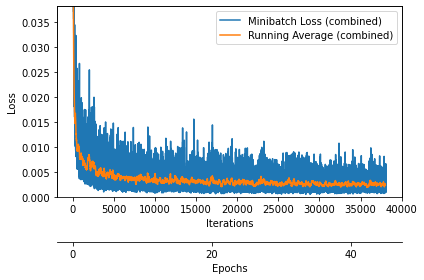

In [10]:
plot_training_loss(log_dict['train_reconstruction_loss_per_batch'], NUM_EPOCHS, custom_label=" (reconstruction)")
plot_training_loss(log_dict['train_kl_loss_per_batch'], NUM_EPOCHS, custom_label=" (KL)")
plot_training_loss(log_dict['train_combined_loss_per_batch'], NUM_EPOCHS, custom_label=" (combined)")
plt.show()



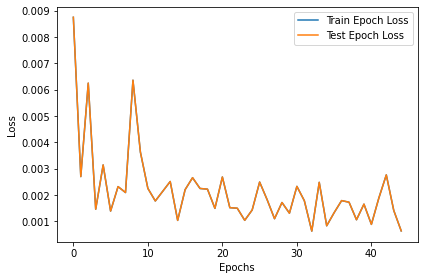

In [11]:
plt.plot(range(len(log_dict['train_combined_loss_per_epoch'])), (log_dict['train_combined_loss_per_epoch']), label='Train Epoch Loss')
plt.plot(range(len(log_dict['test_combined_loss_per_epoch'])), (log_dict['test_combined_loss_per_epoch']), label='Test Epoch Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.ylim(0.15,0.3)
plt.tight_layout()

In [12]:
tmp=df_data.to_numpy(dtype=np.float32)
orginal=copy.deepcopy(tmp)
tmp=stdcs.transform(tmp)
tmp=torch.from_numpy(tmp)
print(tmp.shape)
tmp=tmp[0:12000000,:]
list_of_photons_batches=np.split(tmp,30)
print(len(list_of_photons_batches))

result=np.empty((0,6))
model.eval()
with torch.no_grad():
    for photon_batch in list_of_photons_batches:
        result_encoded_features, z_mean, z_log_var, result_decoded_features =model(photon_batch)#(tmp.to(device=DEVICE))
        result_tmp=result_decoded_features.cpu().detach().numpy()
        result_tmp=stdcs.inverse_transform(result_tmp)
        result =np.append(result, result_tmp,axis=0)
        print(result.shape)

print(result.shape)

torch.Size([12719568, 6])
30
(400000, 6)
(800000, 6)
(1200000, 6)
(1600000, 6)
(2000000, 6)
(2400000, 6)
(2800000, 6)
(3200000, 6)
(3600000, 6)
(4000000, 6)
(4400000, 6)
(4800000, 6)
(5200000, 6)
(5600000, 6)
(6000000, 6)
(6400000, 6)
(6800000, 6)
(7200000, 6)
(7600000, 6)
(8000000, 6)
(8400000, 6)
(8800000, 6)
(9200000, 6)
(9600000, 6)
(10000000, 6)
(10400000, 6)
(10800000, 6)
(11200000, 6)
(11600000, 6)
(12000000, 6)
(12000000, 6)


In [13]:
orginal=orginal[0:12000000,:]

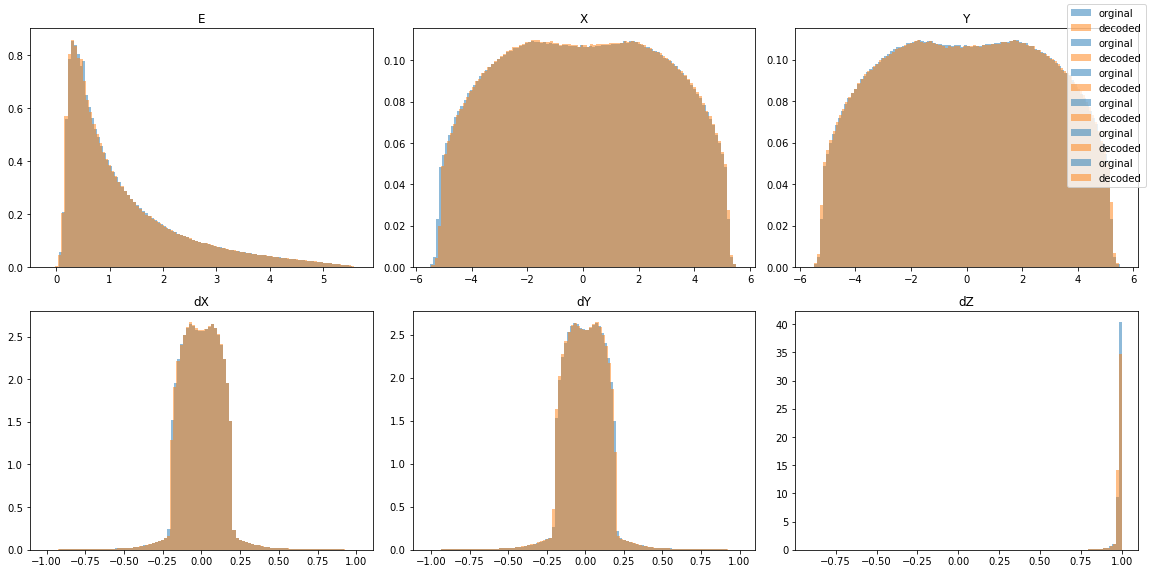

In [14]:
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(16,8)
bins=100
axs[0, 0].hist(orginal[:,0],bins=bins, label ='orginal',alpha=0.5, density=True)
axs[0, 0].hist(result[:,0],bins=bins, label ='decoded', alpha=0.5, density=True)
axs[0, 0].set_title('E')
axs[0, 1].hist(orginal[:,1],bins=bins, label ='orginal',alpha=0.5, density=True)
axs[0, 1].hist(result[:,1],bins=bins, label ='decoded', alpha=0.5, density=True)
axs[0, 1].set_title('X')
axs[0, 2].hist(orginal[:,2],bins=bins, label ='orginal',alpha=0.5, density=True)
axs[0, 2].hist(result[:,2],bins=bins, label ='decoded', alpha=0.5, density=True)
axs[0, 2].set_title('Y')
axs[1, 0].hist(orginal[:,3],bins=bins, label ='orginal',alpha=0.5, density=True)
axs[1, 0].hist(result[:,3],bins=bins, label ='decoded', alpha=0.5, density=True)
axs[1, 0].set_title('dX')
axs[1, 1].hist(orginal[:,4],bins=bins, label ='orginal',alpha=0.5, density=True)
axs[1, 1].hist(result[:,4],bins=bins, label ='decoded', alpha=0.5, density=True)
axs[1, 1].set_title('dY')
axs[1, 2].hist(orginal[:,5],bins=bins, label ='orginal',alpha=0.5, density=True)
axs[1, 2].hist(result[:,5],bins=bins, label ='decoded', alpha=0.5, density=True)
axs[1, 2].set_title('dZ')
fig.legend()

# for ax in axs.flat:
#     ax.set(xlabel='x-label', ylabel='y-label')

# # Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()
fig.tight_layout()

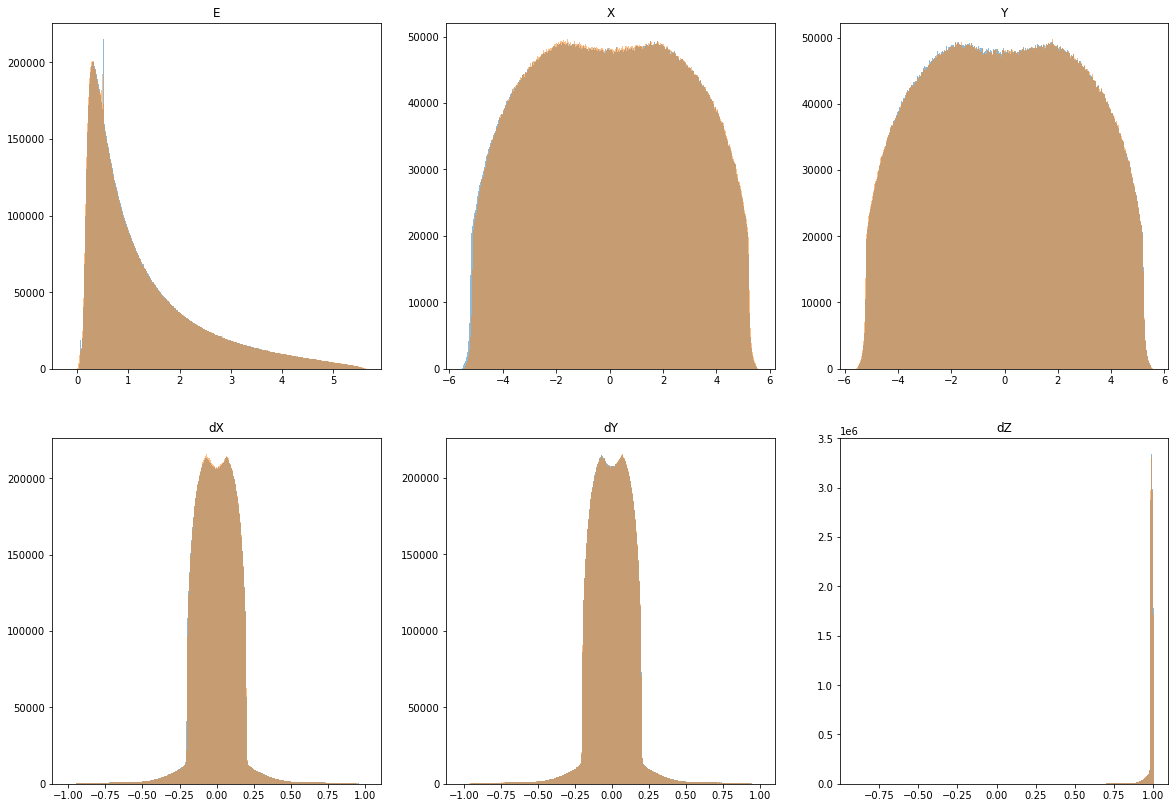

In [15]:
keys = df_data.columns
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(20, 14)
for i, j in enumerate(keys):
    mi = np.minimum(orginal[:, i].min(), result[:, i].min())
    ma = np.maximum(orginal[:, i].max(), result[:, i].max())
    bins = np.linspace(mi, ma, 300)
    axs.flatten()[i].hist(orginal[:, i], bins, alpha=.5)
    axs.flatten()[i].hist(result[:, i], bins, alpha=.5)
    axs.flatten()[i].set_title(j)

(6, 299)


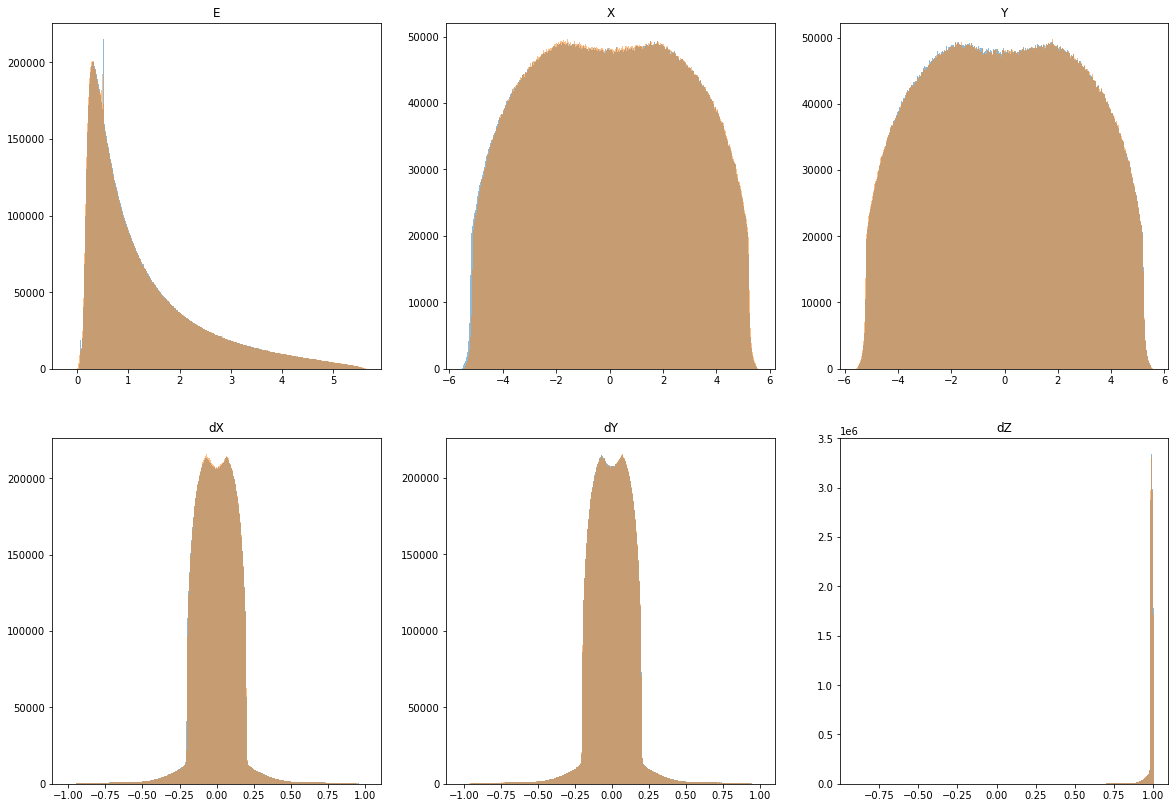

In [16]:
keys = df_data.columns
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(20, 14)

histogram_values_org=np.empty((6,299), dtype=np.int32)
histogram_values_dec=np.empty((6,299), dtype=np.int32)

for i, j in enumerate(keys):
    mi = np.minimum(orginal[:, i].min(), result[:, i].min())
    ma = np.maximum(orginal[:, i].max(), result[:, i].max())
    bins = np.linspace(mi, ma, 300)
    tmp_histogram_org,_,_=axs.flatten()[i].hist(orginal[:, i], bins, alpha=.5)
    tmp_histogram_org=np.asarray(tmp_histogram_org,dtype=np.int32)
    tmp_histogram_dec,_,_=axs.flatten()[i].hist(result[:, i], bins, alpha=.5)
    tmp_histogram_dec=np.asarray(tmp_histogram_dec,dtype=np.int32)
    histogram_values_org[i]=tmp_histogram_org
    histogram_values_dec[i]=tmp_histogram_dec
    # np.append(histogram_values_org[i], tmp_histogram_org,axis=0)
    # np.append(histogram_values_dec[i], tmp_histogram_dec,axis=0)
    axs.flatten()[i].set_title(j)


print(histogram_values_dec.shape)

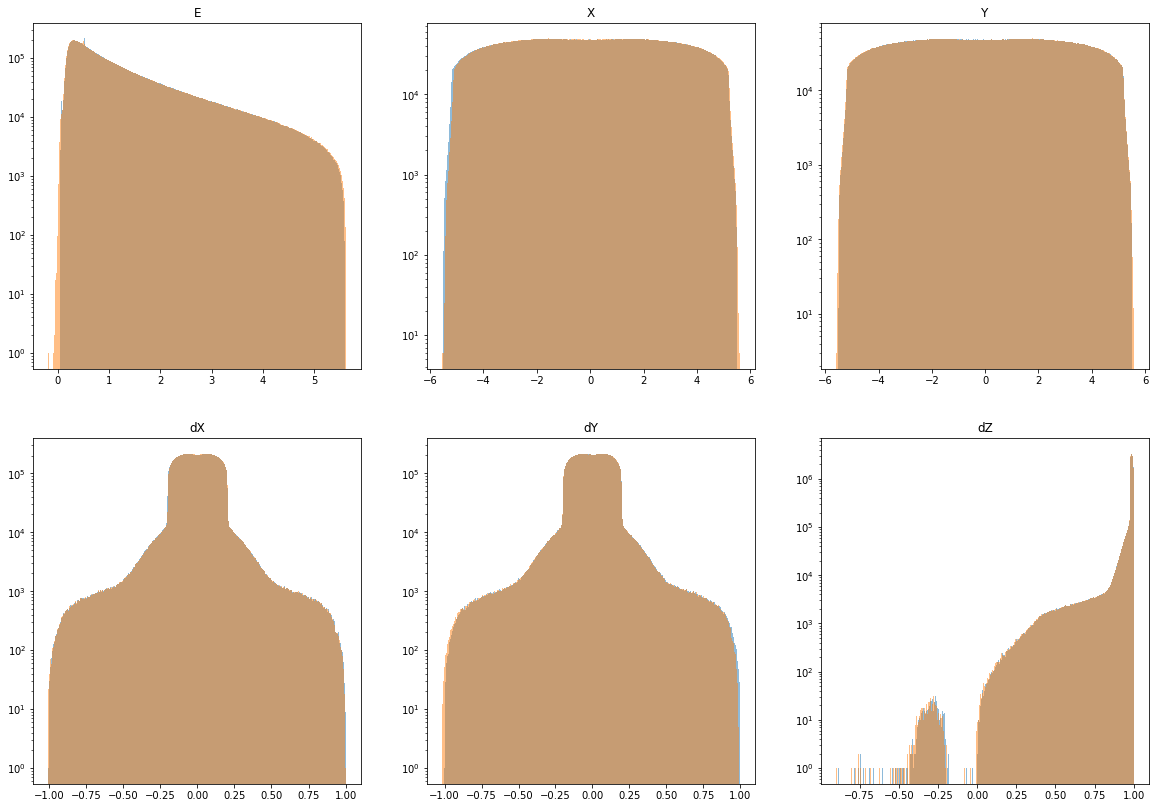

In [17]:
keys = df_data.columns
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(20, 14)

for i, j in enumerate(keys):
    mi = np.minimum(orginal[:, i].min(), result[:, i].min())
    ma = np.maximum(orginal[:, i].max(), result[:, i].max())
    bins = np.linspace(mi, ma, 300)
    axs.flatten()[i].hist(orginal[:, i], bins, alpha=.5, log=True)
    axs.flatten()[i].hist(result[:, i], bins, alpha=.5, log=True)
    axs.flatten()[i].set_title(j)

In [18]:

histogram_approx_error=np.empty((6,299))
for index, key in enumerate(keys):
    for jndex, (bin_org, bin_gen) in enumerate(zip(histogram_values_org[index],histogram_values_dec[index])):
        # print(jndex,bin_gen, bin_org)
        if bin_org==0:
            histogram_approx_error[index][jndex]=100000
        else:
            histogram_approx_error[index][jndex]=abs(bin_org-bin_gen)/bin_org
            # print(bin_org-bin_gen/bin_org)

# print(histogram_approx_error[0])

        


4.468354430379747
0.9510763209393346
14.916666666666666
21.0
51.0
3.5


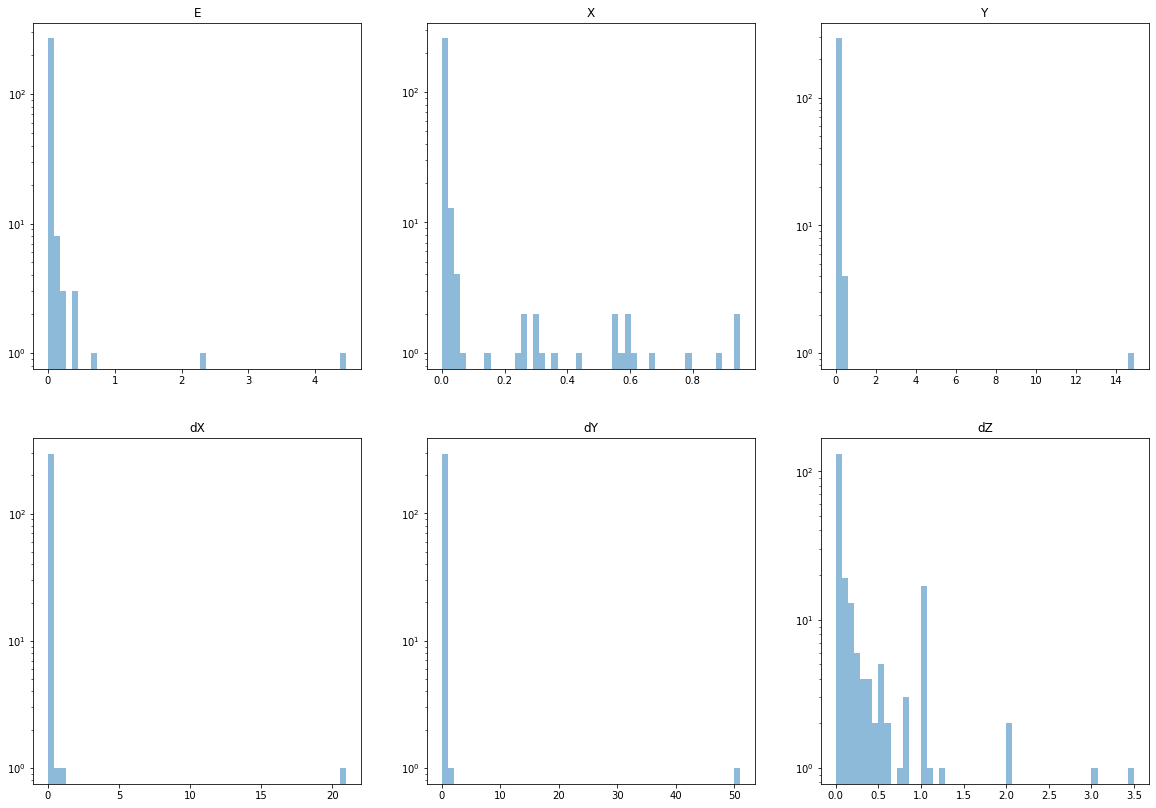

In [19]:
fig2, axs2 = plt.subplots(2, 3)
fig2.set_size_inches(20, 14)

for i, j in enumerate(keys):
    # ma=np.partition(histogram_approx_error[i,:], -2)[-2]
    # mi=np.partition(histogram_approx_error[i,:], 0)[0]
    # print(mi, ma)
    histogram_approx_error[i,:].sort()
    mi = histogram_approx_error[i,0]
    tmp_list=histogram_approx_error[i,:].tolist()
    histogram_approx_error_set=set(tmp_list)
    if int(max(histogram_approx_error_set))==100000:
        histogram_approx_error_set.remove(max(histogram_approx_error_set))
        ma = max(histogram_approx_error_set)
    else:
        ma = max(histogram_approx_error_set)
    print(ma)
    bins = np.linspace(mi, ma, num=50)
    axs2.flatten()[i].hist(histogram_approx_error[i, :], bins, alpha=.5, log=True)
    axs2.flatten()[i].set_title(j)


4.468354430379747
0.9510763209393346
14.916666666666666
21.0
51.0
3.5


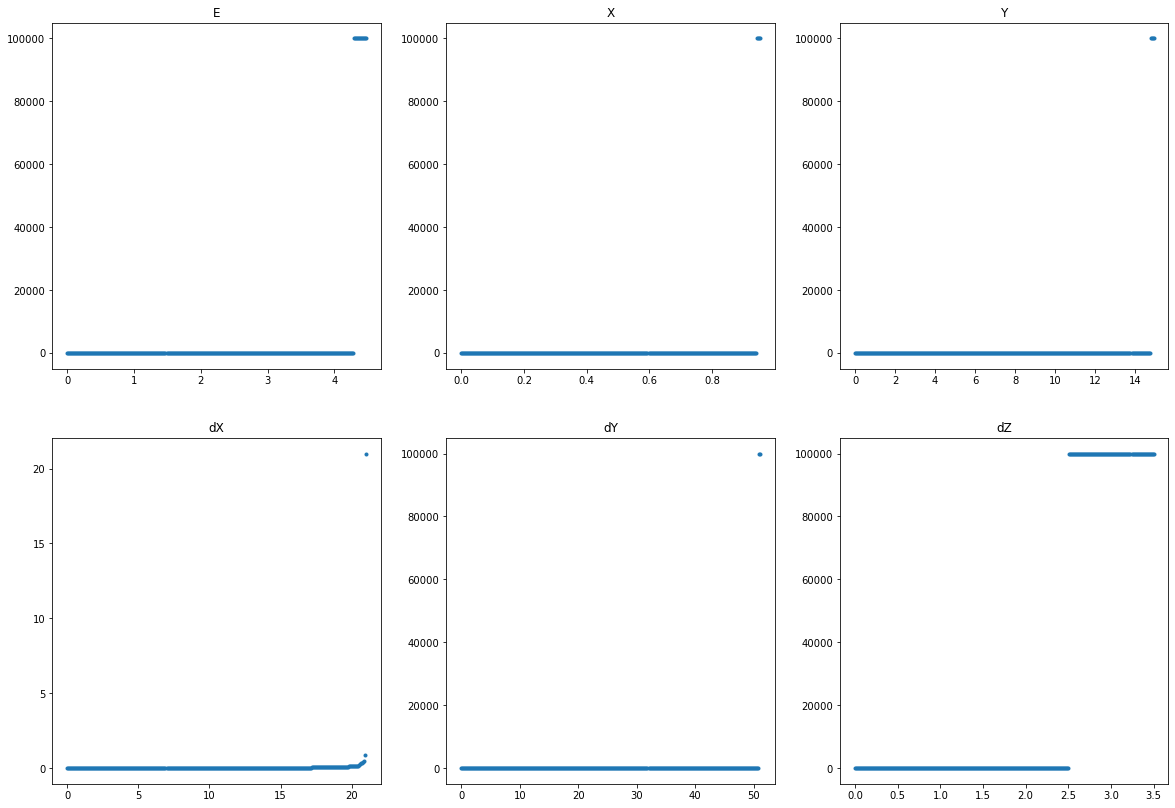

In [20]:
fig3, axs3 = plt.subplots(2, 3)
fig3.set_size_inches(20, 14)

for i, j in enumerate(keys):
    # ma=np.partition(histogram_approx_error[i,:], -2)[-2]
    # mi=np.partition(histogram_approx_error[i,:], 0)[0]
    # print(mi, ma)
    histogram_approx_error[i,:].sort()
    mi = histogram_approx_error[i,0]
    tmp_list=histogram_approx_error[i,:].tolist()
    histogram_approx_error_set=set(tmp_list)
    if int(max(histogram_approx_error_set))==100000:
        histogram_approx_error_set.remove(max(histogram_approx_error_set))
        ma = max(histogram_approx_error_set)
    else:
        ma = max(histogram_approx_error_set)
    print(ma)
    bins = np.linspace(mi, ma, num=299)
    axs3.flatten()[i].plot(bins, histogram_approx_error[i],'.')
    axs3.flatten()[i].set_title(j)

In [21]:
decoded_df=pd.DataFrame(result,columns=['E', 'X', 'Y', 'dX', 'dY', 'dZ'])
orginal_df=df_data.iloc[0:12000000,:]


concatenated_datasets=pd.concat([orginal_df.assign(dataset_name='orginal'), decoded_df.assign(dataset_name='decoded')],ignore_index=True)
concatenated_datasets.shape
print(concatenated_datasets.index.is_unique)

True


In [22]:
#TODO trzeba by sprawdzić czy to losowanie działa poprawnie i zwraca próbkę reprezentatywną
sample_concatenated=concatenated_datasets.groupby('dataset_name', group_keys=False).apply(lambda x: x.sample(frac=FRACTION_PLOT, random_state=2)) 
print(sample_concatenated.shape)
print(sample_concatenated.head())

(300000, 7)
                 E         X         Y        dX        dY        dZ  \
14437473  1.150616  0.761418  1.363275  0.029781  0.054482  0.998173   
20269471  0.958304 -1.925589 -0.471298 -0.254253 -0.132414  0.957221   
13756252  0.354951 -0.940671 -4.694320 -0.037063 -0.180797  0.982327   
23417746  1.945229 -3.090104  0.159301 -0.120974  0.006064  0.992353   
18648255  0.498948 -1.200740 -4.009840 -0.047104 -0.155307  0.986432   

         dataset_name  
14437473      decoded  
20269471      decoded  
13756252      decoded  
23417746      decoded  
18648255      decoded  


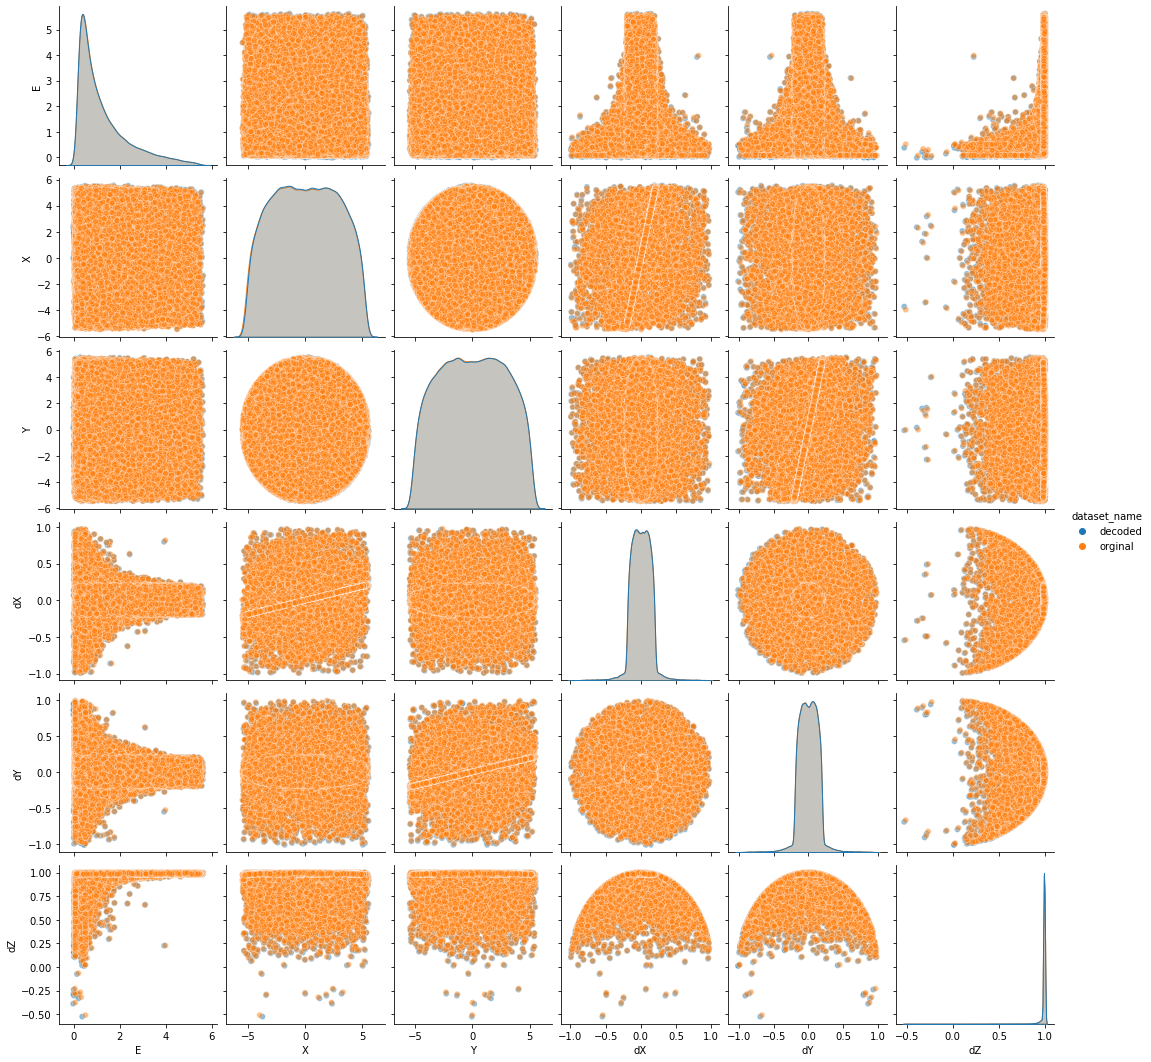

In [23]:
sns.pairplot(sample_concatenated, hue="dataset_name", kind="scatter", plot_kws=dict(alpha=0.5))

In [24]:
sample_orginal=orginal_df.apply(lambda x: x.sample(frac=FRACTION_PLOT*2, random_state=2)) 
print(sample_orginal.shape)
print(sample_orginal.head())

(300000, 6)
                E        X        Y        dX        dY        dZ
2437473   1.15377  0.76565  1.36662  0.030027  0.053582  0.998112
8269471   0.96994 -1.95730 -0.54760 -0.254540 -0.131589  0.958068
1756252   0.36012 -0.99585 -4.67869 -0.038435 -0.180634  0.982799
11417746  1.93774 -3.13463  0.15335 -0.122198  0.005980  0.992488
6648255   0.50057 -1.25227 -3.99408 -0.048590 -0.154789  0.986752


Text(0.5, 1.02, 'Orginal')

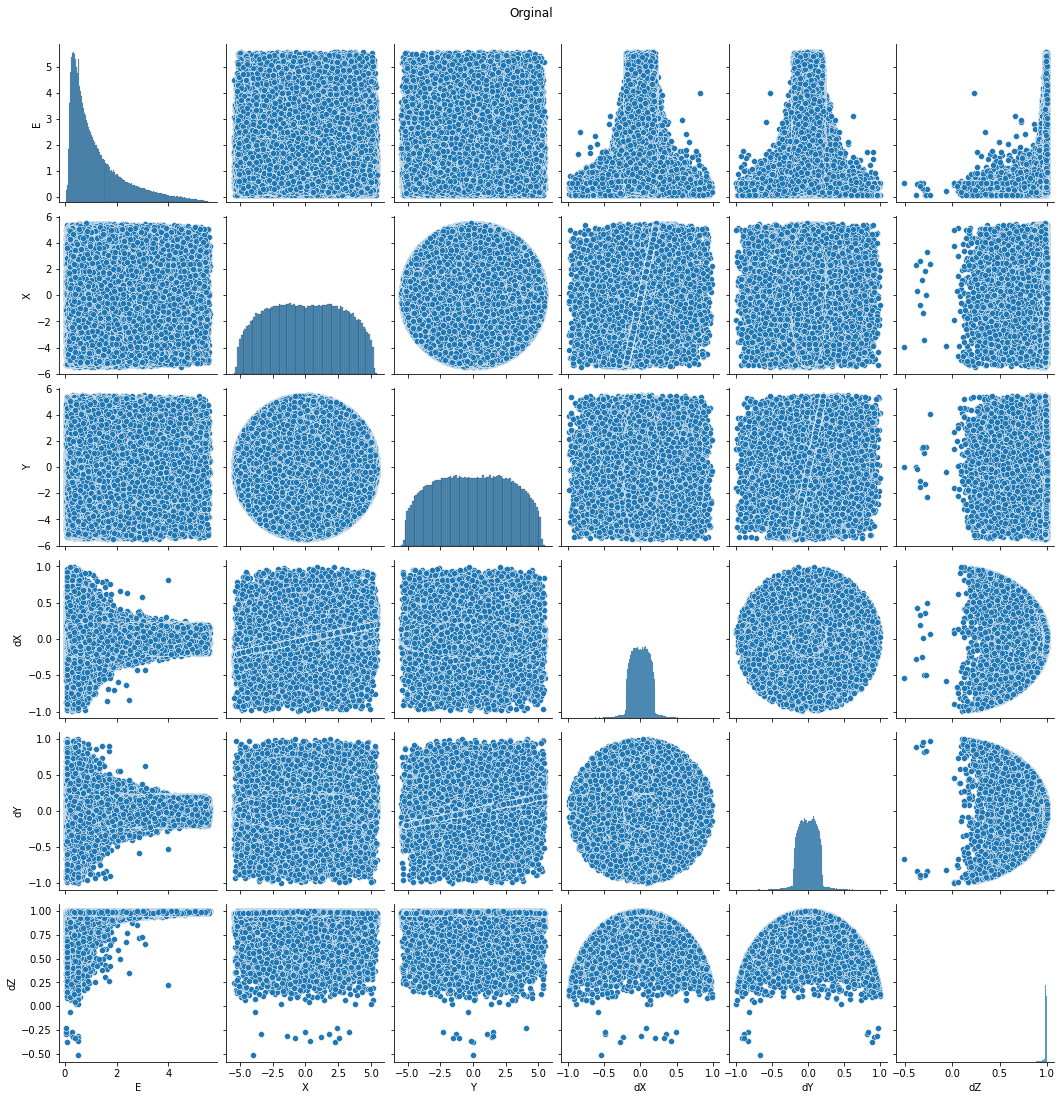

In [25]:
g=sns.pairplot(sample_orginal, kind="scatter")
g.fig.suptitle("Orginal",y=1.02)

In [26]:
sample_decoded=decoded_df.apply(lambda x: x.sample(frac=FRACTION_PLOT*2, random_state=2)) 
print(sample_decoded.shape)
print(sample_decoded.head())

(300000, 6)
                 E         X         Y        dX        dY        dZ
2437473   1.150616  0.761418  1.363275  0.029781  0.054482  0.998173
8269471   0.958304 -1.925589 -0.471298 -0.254253 -0.132414  0.957221
1756252   0.354951 -0.940671 -4.694320 -0.037063 -0.180797  0.982327
11417746  1.945229 -3.090104  0.159301 -0.120974  0.006064  0.992353
6648255   0.498948 -1.200740 -4.009840 -0.047104 -0.155307  0.986432


Text(0.5, 1.02, 'Decoded')

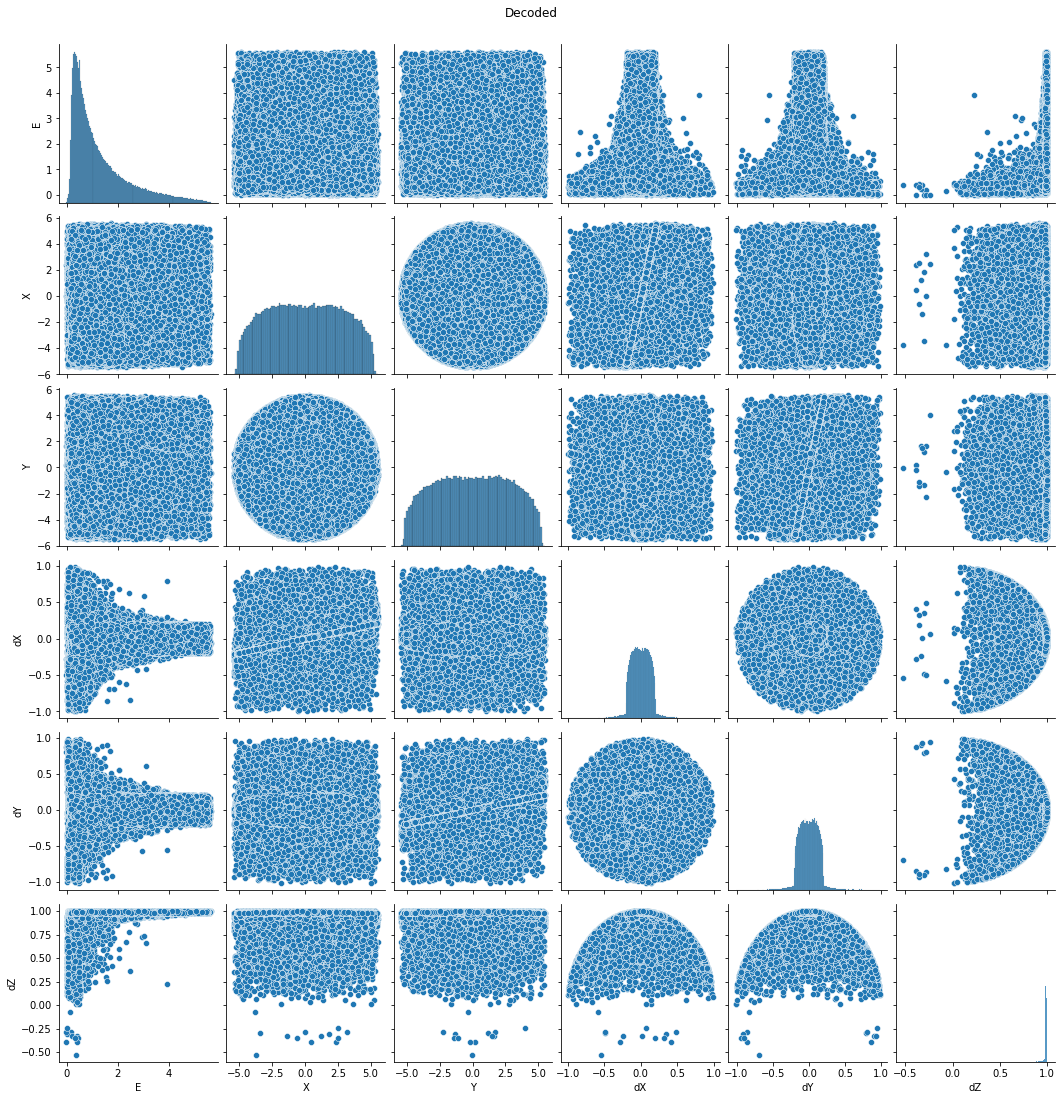

In [27]:
g2=sns.pairplot(sample_decoded, kind="scatter")
g2.fig.suptitle("Decoded",y=1.02)

In [28]:
tmp_2=df_data.iloc[37:38,:]
tmp_2=tmp_2.to_numpy(dtype=np.float32)
orginal_2=tmp_2
tmp_2=stdcs.transform(tmp_2)
tmp_2=torch.from_numpy(tmp_2)
model.eval()
with torch.no_grad():
    result_encoded_features_2, z_mean_2, z_log_var_2, result_decoded_features_2=model(tmp_2)#(tmp_2.to(device=DEVICE))
result_2=result_decoded_features_2.cpu().detach().numpy()
result_2=stdcs.inverse_transform(result_2)

In [29]:
orginal_2=orginal_2.flatten()
result_2=result_2.flatten()

In [30]:
df=pd.DataFrame(np.stack((orginal_2,result_2)), columns=['X', 'Y', 'dX', 'dY', 'dZ', 'E'])
df

X         Y       dX        dY        dZ         E
0  1.193310 -2.587090 -4.31714 -0.099725 -0.166357  0.981010
1  1.183813 -2.547644 -4.32426 -0.098201 -0.166553  0.980566

In [31]:
encoded_features=[]
model.eval()
for index, feature in enumerate(train_loader):
    with torch.no_grad():
        tmp_encoded_features, z_mean, z_log_var, decoded =model(feature)#(feature.to(device=DEVICE))
        encoded_features.extend(tmp_encoded_features.cpu().detach().numpy())
encoded_features=np.asarray(encoded_features)

print(encoded_features.shape)

(7623000, 12)


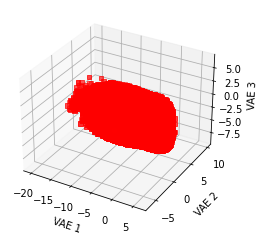

In [32]:
#PRZESTRZEŃ UKRYTA VAE
colors = ['r']
markers = ['s']

fig=plt.figure()
ax=fig.add_subplot(projection='3d')
for c, m in zip(colors, markers):
    ax.scatter(encoded_features[:,0],encoded_features[:,2],encoded_features[:,1],marker=m,c=c)

ax.set_xlabel('VAE 1')
ax.set_ylabel('VAE 2')
ax.set_zlabel('VAE 3')

plt.show()

In [33]:
encoded_features2=[]

tmp=df_data.to_numpy(dtype=np.float32)
orginal=copy.deepcopy(tmp)
tmp=stdcs.transform(tmp)
tmp=torch.from_numpy(tmp)
print(tmp.shape)
tmp=tmp[0:12719550,:]
list_of_photons_batches=np.split(tmp,30)
print(len(list_of_photons_batches))

result=np.empty((0,6))
model.eval()
with torch.no_grad():
    for photon_batch in list_of_photons_batches:
        result_encoded_features, z_mean, z_log_var, result_decoded_features =model(photon_batch)#(tmp.to(device=DEVICE))
        encoded_features2.extend(result_encoded_features.cpu().detach().numpy())
        print(len(encoded_features2))
encoded_features2=np.asarray(encoded_features2)

print(encoded_features2.shape)

torch.Size([12719568, 6])
30
423985
847970
1271955
1695940
2119925
2543910
2967895
3391880
3815865
4239850
4663835
5087820
5511805
5935790
6359775
6783760
7207745
7631730
8055715
8479700
8903685
9327670
9751655
10175640
10599625
11023610
11447595
11871580
12295565
12719550
(12719550, 12)


dZ
-20.058802 6.099643
-8.71635 6.3710036
-6.7972665 10.098615
-3.9749515 10.511483
-10.007917 5.437988
-11.598055 7.3016896
-6.8505745 6.6104007
-6.0328565 9.191476
-5.8957953 7.306193
-11.186985 4.8199277
-3.6701467 8.960601
-10.968355 6.7211633


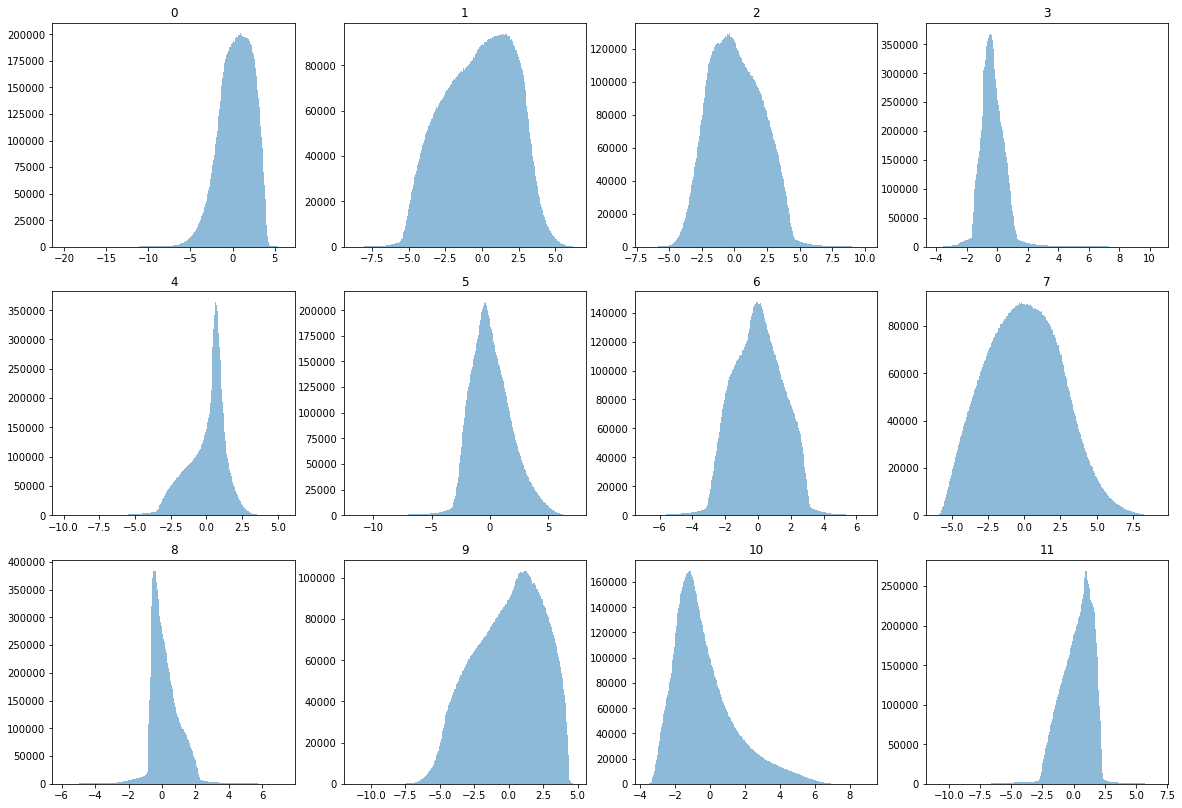

In [34]:
_,dim_encoded=encoded_features2.shape
print(j)
fig, axs = plt.subplots(3, 4)
fig.set_size_inches(20, 14)

for i in range(dim_encoded):
    mi = encoded_features2[:,i].min()
    ma = encoded_features2[:,i].max()
    print(mi,ma)
    # ma = np.maximum(orginal[:, i].max(), result[:, i].max())
    bins = np.linspace(mi, ma, 300)
    axs.flatten()[i].hist(encoded_features2[:, i], bins, alpha=.5)
    axs.flatten()[i].set_title(i)